In [1]:
import pandapower
import pandapower.networks
import pandapower.plotting
import pandapower.topology
import pandapower.converter
import pandapower.estimation

## Numpy has to be version 1.26.4 or lower, because they changed the name of the INF constant, also pyproj is required (not stated in the documentation)

In [1]:
import pandapower.test
pandapower.test.run_all_tests()

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.2.2, pluggy-1.5.0
rootdir: /home/moritz/PycharmProjects/GridComm-Cosimulation
plugins: anyio-4.4.0
collected 1046 items

.venv/lib/python3.10/site-packages/pandapower/test/api/test_auxiliary.py ............
.venv/lib/python3.10/site-packages/pandapower/test/api/test_convert_format.py ....................................
.venv/lib/python3.10/site-packages/pandapower/test/api/test_create.py ...........................
.venv/lib/python3.10/site-packages/pandapower/test/api/test_diagnostic.py .............zgstrf info 25
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
zgstrf info 27
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
dgstrf info 1
.........
.venv/lib/python3.10/site-packages/pandapower/tes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandapower as pp
import os
import pandapower.topology as top
import pandapower.plotting as plot
import simbench as sb

In [2]:
sb_code = "1-LV-semiurb4--0-sw"
net = sb.get_simbench_net(sb_code)

In [3]:
net

This pandapower network includes the following parameter tables:
   - bus (44 elements)
   - load (41 elements)
   - sgen (1 element)
   - switch (86 elements)
   - ext_grid (1 element)
   - line (42 elements)
   - trafo (1 element)
   - bus_geodata (44 elements)
   - loadcases (6 elements)

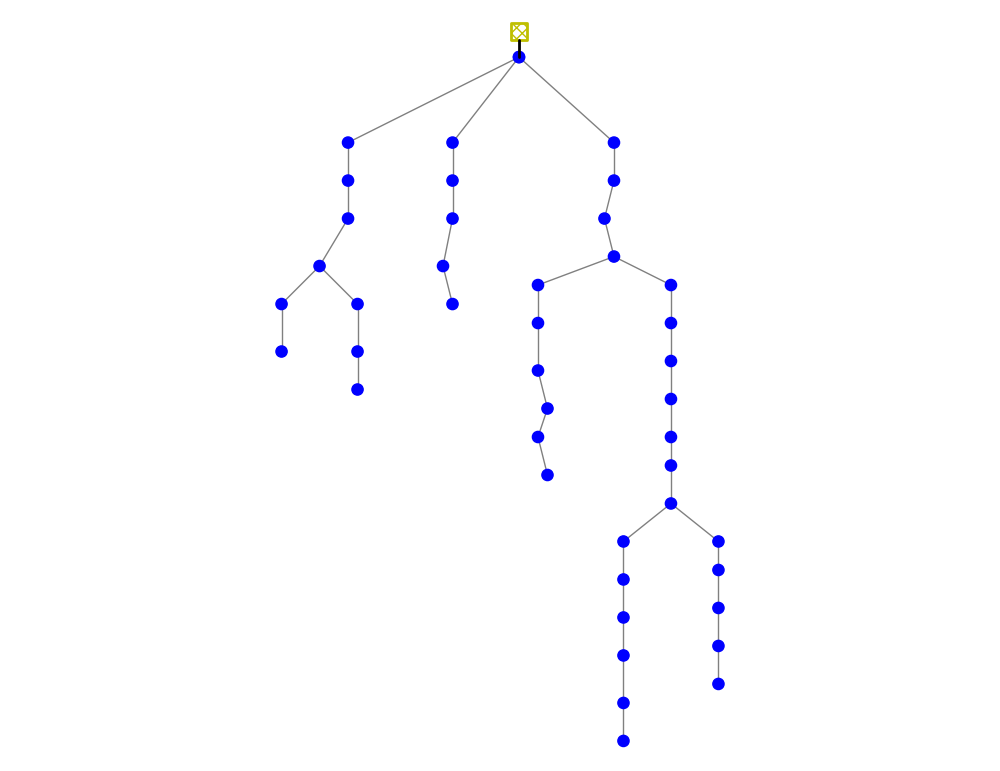

<Axes: >

In [4]:
plot.simple_plot(net)

In [8]:
net.loadcases

,pload,qload,Wind_p,PV_p,RES_p,Slack_vm
Study Case,,,,,,
hL,1.0,1.000000,0.00,0.00,0.0,0.965
n1,1.0,1.000000,0.00,0.00,0.0,0.965
hW,1.0,1.000000,1.00,0.80,1.0,0.965
hPV,1.0,1.000000,0.85,0.95,1.0,0.965
lW,0.1,0.122543,1.00,0.80,1.0,1.055
lPV,0.1,0.122543,0.85,0.95,1.0,1.055


In [9]:
loadcases = sb.get_absolute_values(net, profiles_instead_of_study_cases=True)

def apply_absolute_values(net, absolute_values_dict, case_or_time_step):
    for elm_param in absolute_values_dict.keys():
        if absolute_values_dict[elm_param].shape[1]:
            elm = elm_param[0]
            param = elm_param[1]
            net[elm].loc[:, param] = absolute_values_dict[elm_param].loc[case_or_time_step]

In [10]:
net.sgen.profile.iloc[0]
assert not sb.profiles_are_missing(net)

In [12]:
profiles = sb.get_absolute_values(net, profiles_instead_of_study_cases=True)
time_steps = range(96)
net.trafo.tap_pos = 1
results = pd.DataFrame([], index=time_steps, columns=["Load Sum", "min_vm_pu", "max_vm_pu"])
for time_step in time_steps:
    apply_absolute_values(net, profiles, time_step)
    pp.runpp(net)
    results.loc[time_step, "Load Sum"] = net.res_load.p_mw.sum()
    results.loc[time_step, "min_vm_pu"] = net.res_bus.vm_pu.min()
    results.loc[time_step, "max_vm_pu"] = net.res_bus.vm_pu.max()

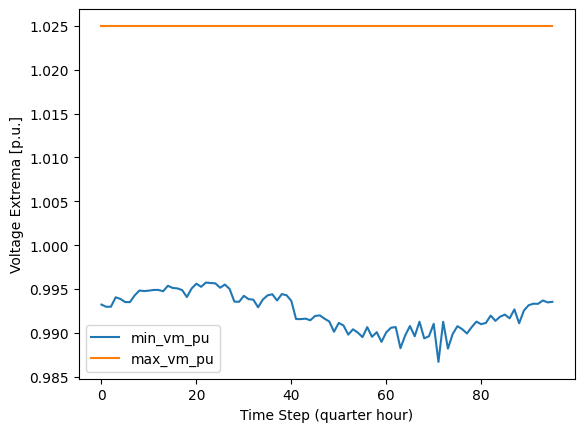

In [13]:
fig1, ax1 = plt.subplots()
results[["min_vm_pu", "max_vm_pu"]].plot(ax=ax1)
ax1.set_ylabel("Voltage Extrema [p.u.]")
ax1.set_xlabel("Time Step (quarter hour)")
plt.show()

## Using the Timeseries Module of pandapower

In [14]:
import tempfile
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries

sb.apply_const_controllers(net, profiles)
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".json")
ow.log_variable("res_load", "p_mw", eval_function=np.sum, eval_name="Load Sum")
ow.log_variable("res_bus", "vm_pu", eval_function=np.min, eval_name="min_vm_pu")
ow.log_variable("res_bus", "vm_pu", eval_function=np.max, eval_name="max_vm_pu")

run_timeseries(net, time_steps)

vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.json")
vm_pu = pd.read_json(vm_pu_file)
load_p_file = os.path.join(output_dir, "res_load", "p_mw.json")
load_p = pd.read_json(load_p_file)
result = pd.concat([load_p[["Load Sum"]], vm_pu[["min_vm_pu", "max_vm_pu"]]], axis=1)
result.sort_index(inplace=True)

/home/moritz/PycharmProjects/GridComm-Cosimulation/.venv/lib/python3.10/site-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 96)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
/home/moritz/PycharmProjects/GridComm-Cosimulation/.venv/lib/python3.10/site-packages/pandapower/control/run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 96/96 [00:01<00:00, 49.75it/s]
/tmp/ipykernel_3723/2774399563.py:17: FutureWarning: The behavior of 'to_datetime' with 'un

In [15]:
results.head()

,Load Sum,min_vm_pu,max_vm_pu
0,0.041162,0.993219,1.025
1,0.033502,0.992967,1.025
2,0.036333,0.992979,1.025
3,0.032689,0.994052,1.025
4,0.035421,0.993864,1.025


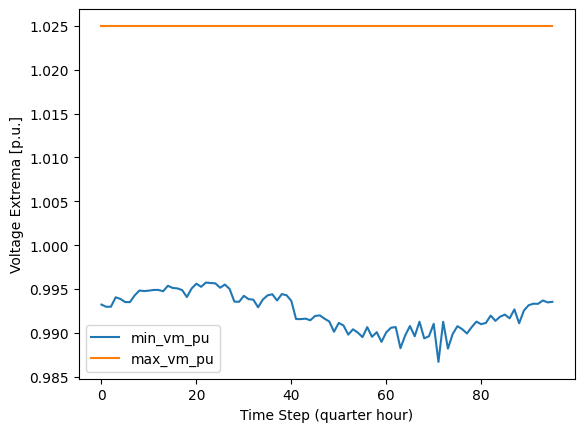

In [16]:
fig1, ax1 = plt.subplots()
results[["min_vm_pu", "max_vm_pu"]].plot(ax=ax1)
ax1.set_ylabel("Voltage Extrema [p.u.]")
ax1.set_xlabel("Time Step (quarter hour)")
plt.show()

## Using MOSAIK

In [17]:
import nest_asyncio
nest_asyncio.apply()

In [20]:
import mosaik
import mosaik.util
import mosaik_pandapower

SIM_CONFIG = {
    'Grid': {
        'python': 'mosaik_pandapower.simulator:Pandapower',
    }
}
END = 600

world = mosaik.World(SIM_CONFIG)


GRID_FILE = "1-LV-semiurb4--0-sw"
gridsim = world.start('Grid', step_size=900)
grid = gridsim.Grid(gridfile=GRID_FILE).children

world.run(until=END)


        ____                              _ _
       /    \                            (_) |
  ____/      \  _ __ ___   ___  ___  __ _ _| | __
 /    \      / | '_ ` _ \ / _ \/ __|/ _` | | |/ / 
/      \____/  | | | | | | (_) \__ \ (_| | |   <     
\      /    \  |_| |_| |_|\___/|___/\__,_|_|_|\_\    
 \____/      \____
 /    \      /    \    mosaik version:     3.3.3
/      \____/      \   mosaik API version: 3.0.10
\      /    \      /   Python version:     3.10.12
 \____/      \____/    OS:                 Linux-6.5.0-35-generic-x86_64-with-glibc2.35
      \      /         Documentation:      https://mosaik.readthedocs.io/en/3.3.3/
       \____/          Get in touch:       https://github.com/orgs/OFFIS-mosaik/discussions


2024-06-17 23:24:28.708 | INFO     | mosaik.scenario:start:311 - Starting "Grid" as "Grid-0" ...
/home/moritz/PycharmProjects/GridComm-Cosimulation/.venv/lib/python3.10/site-packages/pandapower/timeseries/output_writer.py:177: FutureWarning: Setting an item of in